In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file to explore its content and structure
data = pd.read_csv('All Distributed Unfunded Aid by Admit Status 20240314-104043 (1).csv')

# Display the first few rows of the dataframe and the column names to understand the dataset
data.head(), data.columns


(   Unique ID Application Submitted Date                             College  \
 0  999789535                   10/10/23           Albers School of Business   
 1  982505163                   19/12/23           Albers School of Business   
 2  999851695                   31/01/21                College of Education   
 3  978092429                   15/12/23           Albers School of Business   
 4  976965474                   28/03/22  College of Science and Engineering   
 
                                  Application Program Application Start Term  \
 0  Business Administration (Professional) - MBA -...            Winter 2024   
 1           Sport and Entertainment Management - MBA            Winter 2024   
 2  Counseling, Clinical Mental Health Counseling ...              Fall 2021   
 3  Business Administration (Professional) - MBA -...            Winter 2024   
 4          Computer Science Fundamentals Certificate            Winter 2024   
 
                     Decision Reason

<Figure size 1000x600 with 0 Axes>

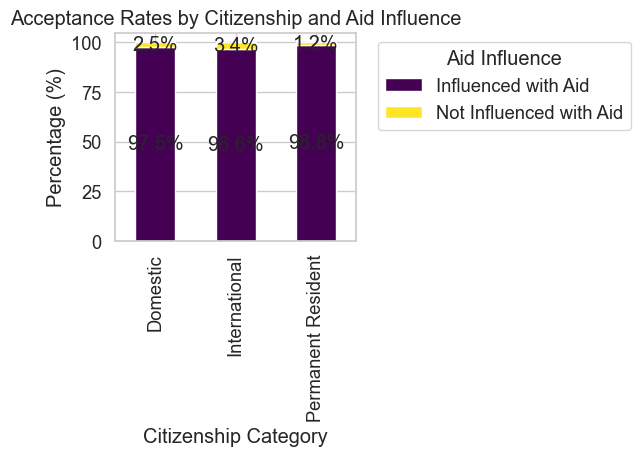

In [3]:


# Data cleaning and preprocessing
# Correcting the Scholarship Tier format
data['Application Scholarship Tier'] = data['Application Scholarship Tier'].replace({'2022-G1 - $0': '2022-G0 - $0'})

# Extracting the scholarship amount and converting it to numeric
data['Scholarship Amount'] = data['Application Scholarship Tier'].str.extract(r'(\d+)').fillna(0).astype(int)

# Define influenced groups based on corrected conditions
def determine_aid_influence(row):
    influenced_decisions = [
        'Admit Conditional', 'Admit Conditional & Bridge', 'Admit Conditional & Probationary',
        'Admit Probation', 'Admit Regular', 'Deposit - Not Required', 'Deposit Paid',
        'Deposit Waived/Not Required'
    ]
    not_influenced_decisions = ['Admit Declined - Post Enroll(CF)', 'No Show - Post Enroll(CF)', 'Admit Declined']

    if row['Scholarship Amount'] > 0 and row['Registered in Colleague'] == 1 and row['Decision Reason'] in influenced_decisions:
        return 'Influenced with Aid'
    elif row['Scholarship Amount'] > 0 and (row['Registered in Colleague'] == 0 or (row['Registered in Colleague'] == 1 and row['Decision Reason'] in not_influenced_decisions)):
        return 'Not Influenced with Aid'
    else:
        return 'No Aid'

data['Aid Influence'] = data.apply(determine_aid_influence, axis=1)

# Categorizing citizenship
def categorize_citizenship(status):
    if status == 'US':
        return 'Domestic'
    elif status == 'PR':
        return 'Permanent Resident'
    elif status == 'FN':
        return 'International'

data['Citizenship Category'] = data['Person Citizenship Status'].apply(categorize_citizenship)

# Filter data for students who accepted their offer (assumed to have Registered in Colleague == 1)
accepted_offers = data[data['Registered in Colleague'] == 1]

# Calculate the percentages for aid influence within each citizenship category
acceptance_rates = accepted_offers.groupby(['Citizenship Category', 'Aid Influence']).size().unstack(fill_value=0)
acceptance_rates_percentage = acceptance_rates.div(acceptance_rates.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)  # For better readability and a suitable style for accessibility

ax = acceptance_rates_percentage.plot(kind='bar', stacked=True, colormap='viridis')
ax.set_xlabel('Citizenship Category')
ax.set_ylabel('Percentage (%)')
ax.set_title('Acceptance Rates by Citizenship and Aid Influence')
ax.legend(title='Aid Influence', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding data labels
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np

# Adjust the citizenship classification
data['Citizenship Category'] = data['Person Citizenship Status'].apply(lambda x: 'Domestic' if x in ['US', 'PR'] else 'International')

# Define influenced and not influenced based on conditions provided
# Scholarship >$0 and registered for classes (colleague=1) and decision reason in the influenced list
influenced_decision_reasons = [
    'Admit Conditional', 'Admit Conditional & Bridge', 'Admit Conditional & Probationary',
    'Admit Probation', 'Admit Regular', 'Deposit - Not Required', 'Deposit Paid', 'Deposit Waived/Not Required'
]

not_influenced_decision_reasons = [
    'Admit Declined - Post Enroll(CF)', 'No Show - Post Enroll(CF)', 'Admit Declined'
]

# Extract the monetary value from scholarship tier
data['Scholarship Amount'] = data['Application Scholarship Tier'].apply(lambda x: float(x.split('- $')[-1].replace(',', '')) if '$' in x else 0)

# Define influenced status
data['Influenced'] = np.where(
    (data['Scholarship Amount'] > 0) & 
    (data['Registered in Colleague'] == 1) & 
    (data['Decision Reason'].isin(influenced_decision_reasons)), 
    'Influenced', 
    'Not Influenced'
)

# Update not influenced status correctly
data.loc[
    (data['Scholarship Amount'] > 0) & 
    ((data['Registered in Colleague'] == 0) | data['Decision Reason'].isin(not_influenced_decision_reasons)),
    'Influenced'
] = 'Not Influenced'

# Check the distribution of influenced vs. not influenced
influenced_counts = data['Influenced'].value_counts(normalize=True)
influenced_counts


Influenced
Not Influenced    0.883642
Influenced        0.116358
Name: proportion, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Preparing data for logistic regression
# Encode categorical variables
encoder = LabelEncoder()
data_encoded = data.copy()
data_encoded['Person Sex Encoded'] = encoder.fit_transform(data_encoded['Person Sex'])
data_encoded['Person Race Encoded'] = encoder.fit_transform(data_encoded['Person Race'])
data_encoded['Citizenship Category Encoded'] = encoder.fit_transform(data_encoded['Citizenship Category'])

# Features and target
features = data_encoded[['Age', 'Person Sex Encoded', 'Person Race Encoded', 'Scholarship Amount', 'Citizenship Category Encoded']]
target = data_encoded['Influenced'].apply(lambda x: 1 if x == 'Influenced' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict on test data
y_pred = logistic_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.8729486500794071

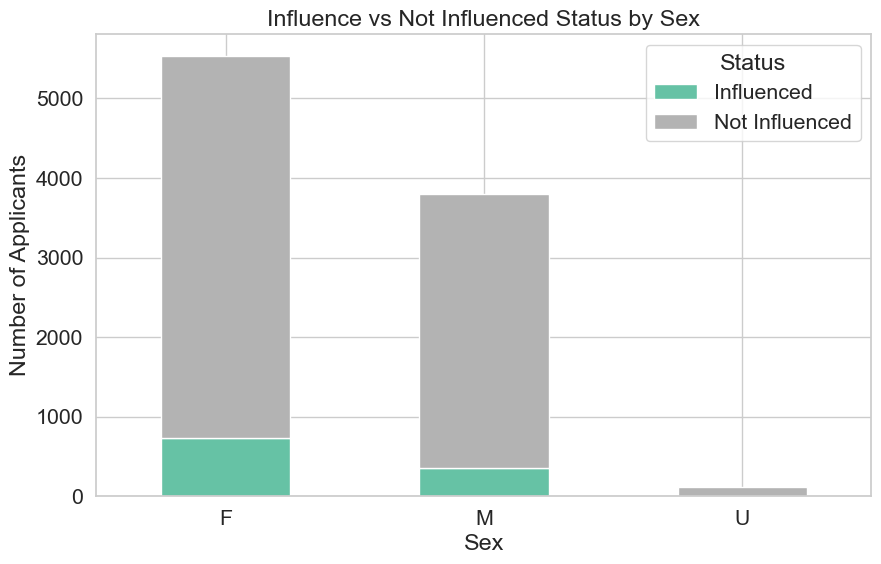

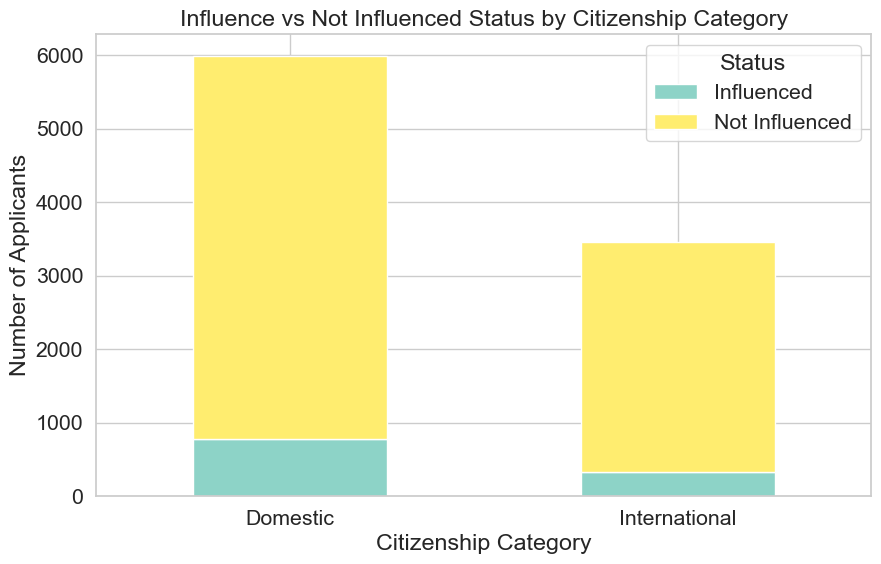

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid", font_scale=1.4)

# Prepare data for plotting
sex_influence_data = data.groupby(['Person Sex', 'Influenced']).size().unstack().fillna(0)
citizenship_influence_data = data.groupby(['Citizenship Category', 'Influenced']).size().unstack().fillna(0)

# Plot 1: Influence vs Not Influenced Status by Sex
plt.figure(figsize=(10, 6))
sex_influence_data.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())
plt.title('Influence vs Not Influenced Status by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Applicants')
plt.legend(title='Status')
plt.xticks(rotation=0)
plt.show()

# Plot 2: Influence vs Not Influenced Status by Citizenship Category (Domestic/International)
plt.figure(figsize=(10, 6))
citizenship_influence_data.plot(kind='bar', stacked=True, colormap='Set3', ax=plt.gca())
plt.title('Influence vs Not Influenced Status by Citizenship Category')
plt.xlabel('Citizenship Category')
plt.ylabel('Number of Applicants')
plt.legend(title='Status')
plt.xticks(rotation=0)
plt.show()


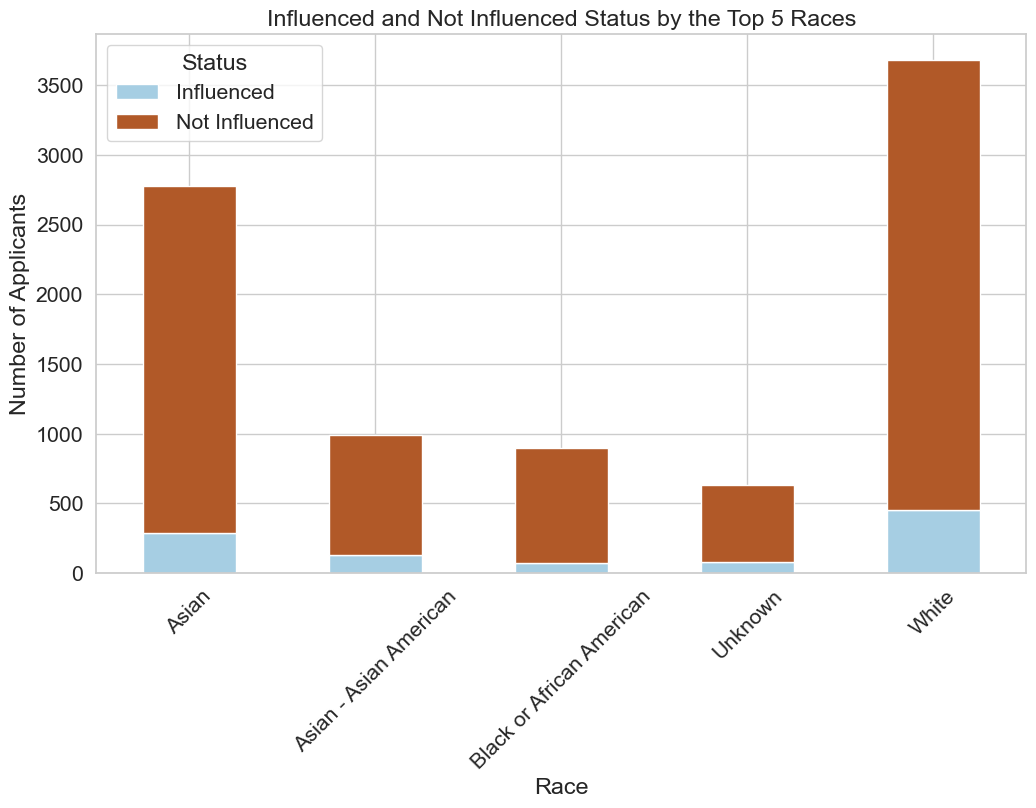

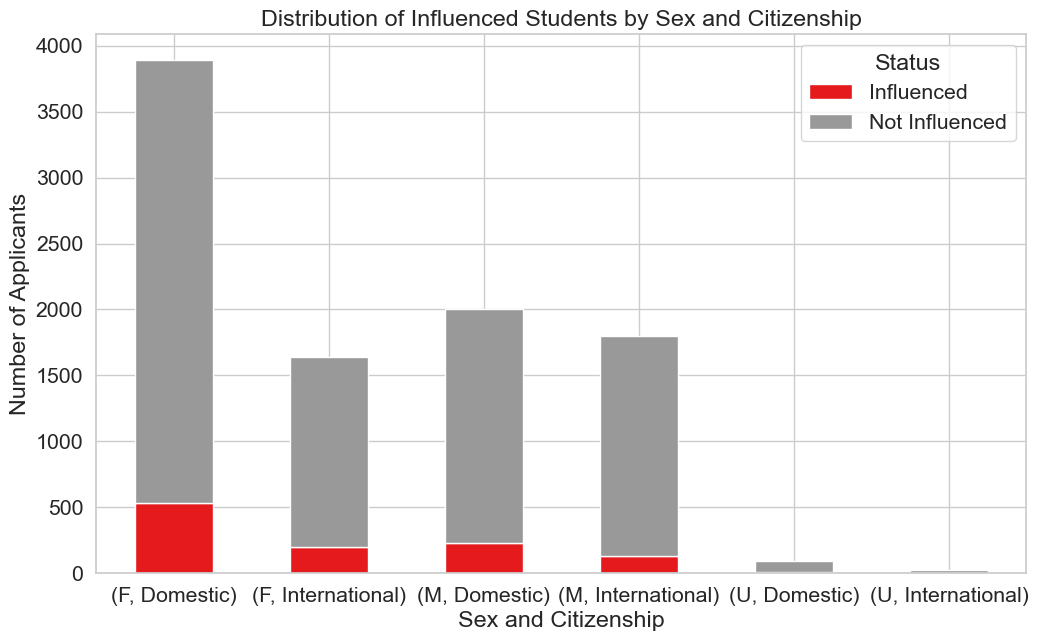

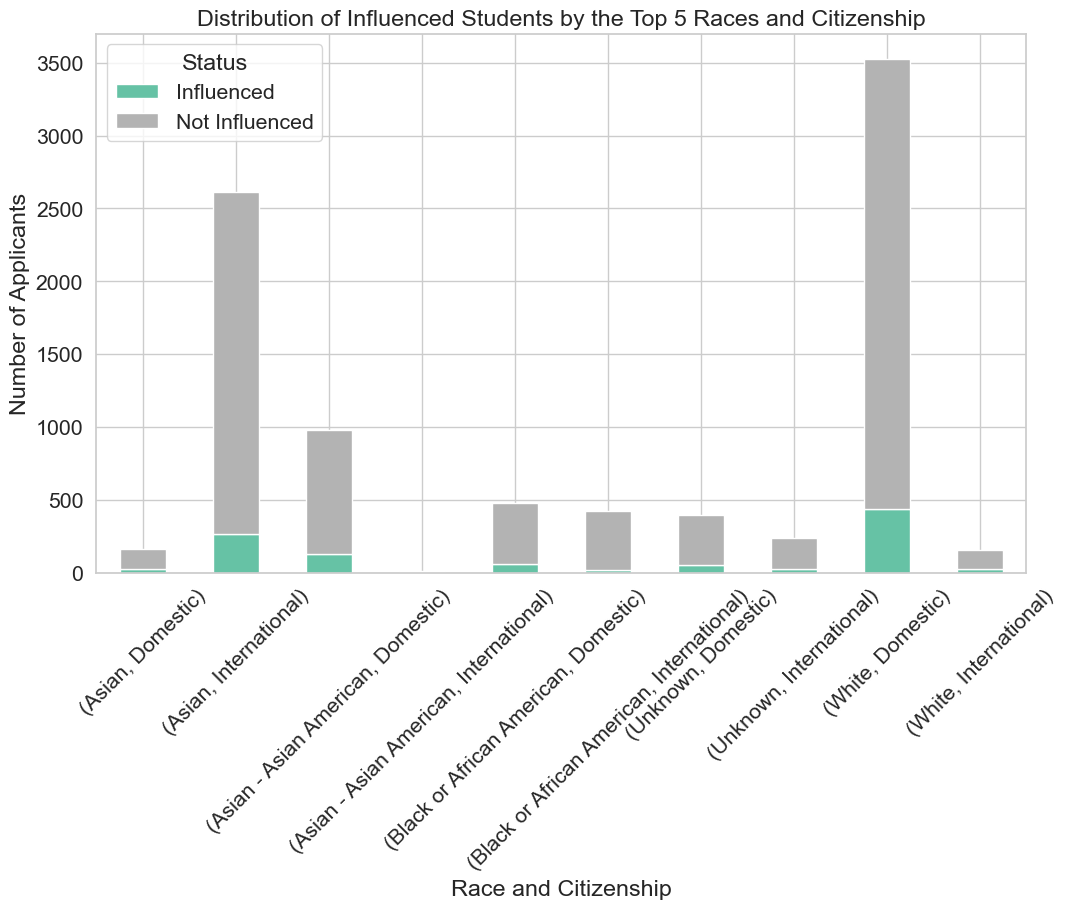

In [23]:
# Prepare data for plotting by top 5 races
top_5_races = data['Person Race'].value_counts().nlargest(5).index
race_influence_data = data[data['Person Race'].isin(top_5_races)]
race_influence_grouped = race_influence_data.groupby(['Person Race', 'Influenced']).size().unstack().fillna(0)

# Plot 3: Influenced and Not Influenced Status by the Top 5 Races
plt.figure(figsize=(12, 7))
race_influence_grouped.plot(kind='bar', stacked=True, colormap='Paired', ax=plt.gca())
plt.title('Influenced and Not Influenced Status by the Top 5 Races')
plt.xlabel('Race')
plt.ylabel('Number of Applicants')
plt.legend(title='Status')
plt.xticks(rotation=45)
plt.show()

# Prepare data for combined demographic plots
sex_citizenship_influence_data = data.groupby(['Person Sex', 'Citizenship Category', 'Influenced']).size().unstack().fillna(0)
race_citizenship_influence_data = race_influence_data.groupby(['Person Race', 'Citizenship Category', 'Influenced']).size().unstack().fillna(0)

# Plot 4: Distribution of Influenced Students by Sex and Citizenship
plt.figure(figsize=(12, 7))
sex_citizenship_influence_data.plot(kind='bar', stacked=True, colormap='Set1', ax=plt.gca())
plt.title('Distribution of Influenced Students by Sex and Citizenship')
plt.xlabel('Sex and Citizenship')
plt.ylabel('Number of Applicants')
plt.legend(title='Status')
plt.xticks(rotation=0)
plt.show()

# Plot 5: Distribution of Influenced Students by the Top 5 Races and Citizenship
plt.figure(figsize=(12, 7))
race_citizenship_influence_data.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())
plt.title('Distribution of Influenced Students by the Top 5 Races and Citizenship')
plt.xlabel('Race and Citizenship')
plt.ylabel('Number of Applicants')
plt.legend(title='Status')
plt.xticks(rotation=45)
plt.show()


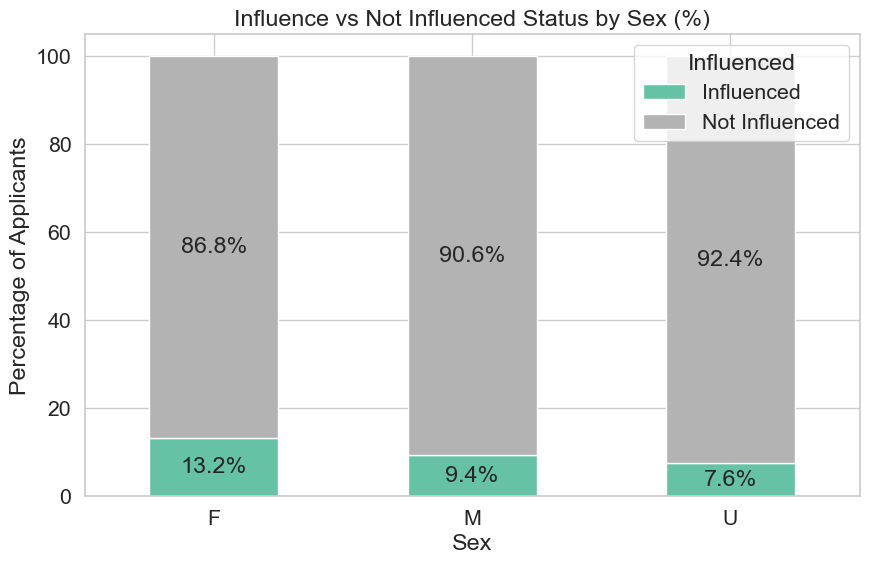

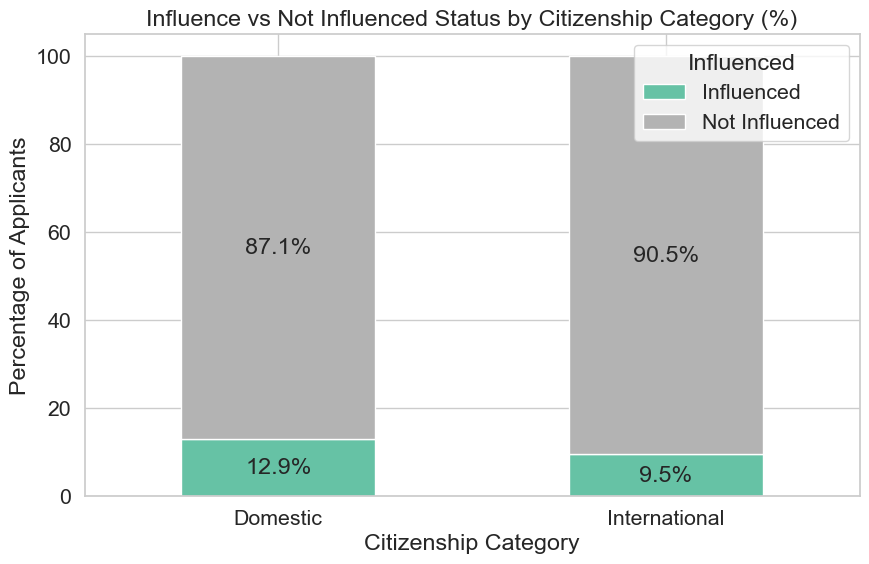

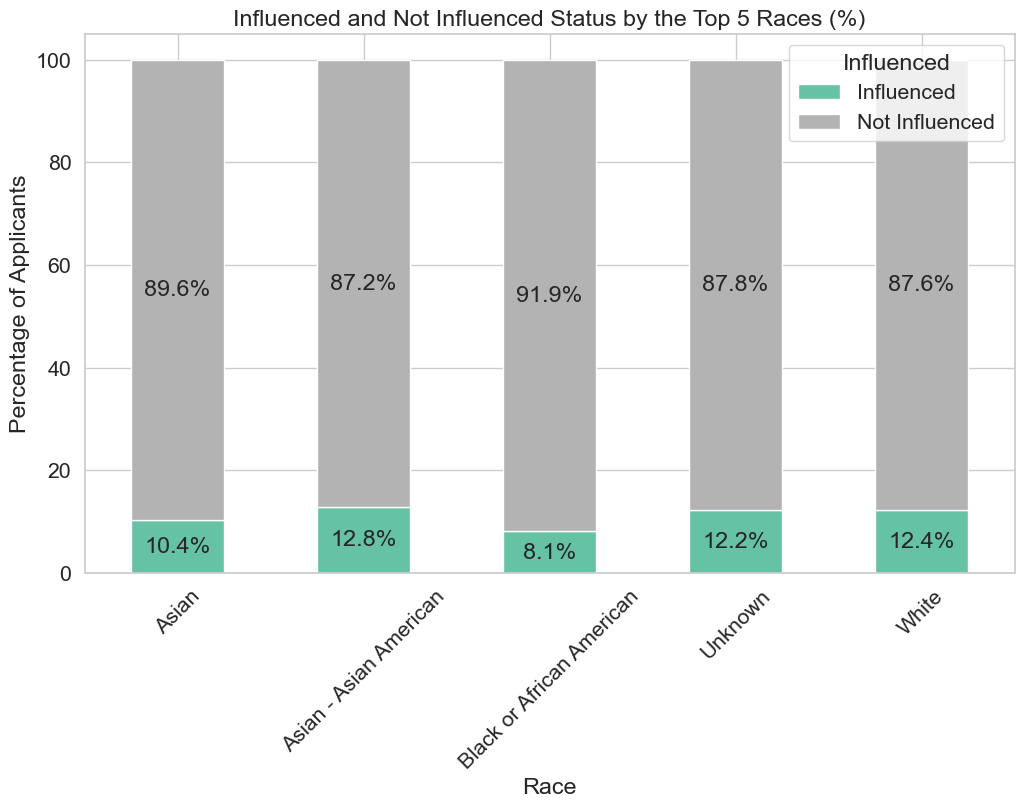

In [24]:
def plot_stacked_bar(data, title, xlabel, ylabel, ax, rotation=0):
    # Calculate percentages
    data_percentage = data.div(data.sum(axis=1), axis=0) * 100
    
    # Plot
    bars = data_percentage.plot(kind='bar', stacked=True, colormap='Set2', ax=ax)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    
    # Adding data labels
    for bar in bars.containers:
        bars.bar_label(bar, fmt='%.1f%%', label_type='center')

# Plot 1: Influence vs Not Influenced Status by Sex with percentages
plt.figure(figsize=(10, 6))
plot_stacked_bar(sex_influence_data, 'Influence vs Not Influenced Status by Sex (%)', 'Sex', 'Percentage of Applicants', plt.gca())

# Plot 2: Influence vs Not Influenced Status by Citizenship Category with percentages
plt.figure(figsize=(10, 6))
plot_stacked_bar(citizenship_influence_data, 'Influence vs Not Influenced Status by Citizenship Category (%)', 'Citizenship Category', 'Percentage of Applicants', plt.gca())

# Plot 3: Influenced and Not Influenced Status by the Top 5 Races with percentages
plt.figure(figsize=(12, 7))
plot_stacked_bar(race_influence_grouped, 'Influenced and Not Influenced Status by the Top 5 Races (%)', 'Race', 'Percentage of Applicants', plt.gca(), rotation=45)

plt.show()


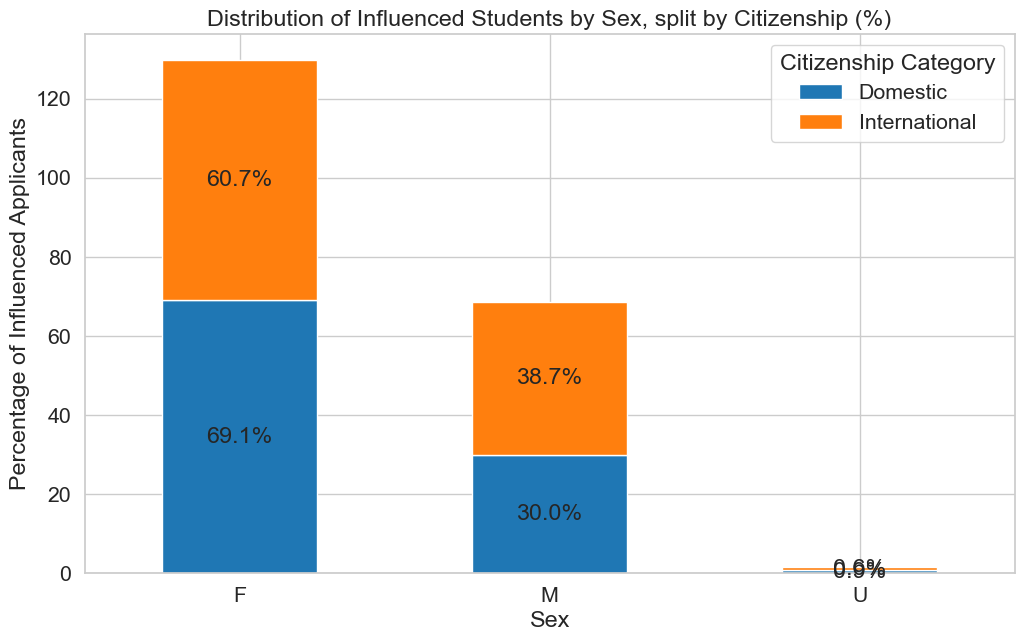

In [25]:
# Adjust the data plotting with sex on the x-axis and stacked by citizenship category
plt.figure(figsize=(12, 7))
bars = sex_citizenship_influenced_percentage.T.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
plt.title('Distribution of Influenced Students by Sex, split by Citizenship (%)')
plt.xlabel('Sex')
plt.ylabel('Percentage of Influenced Applicants')
plt.xticks(rotation=0)
plt.legend(title='Citizenship Category', labels=['Domestic', 'International'])
for bar in bars.containers:
    bars.bar_label(bar, fmt='%.1f%%', label_type='center')

plt.show()


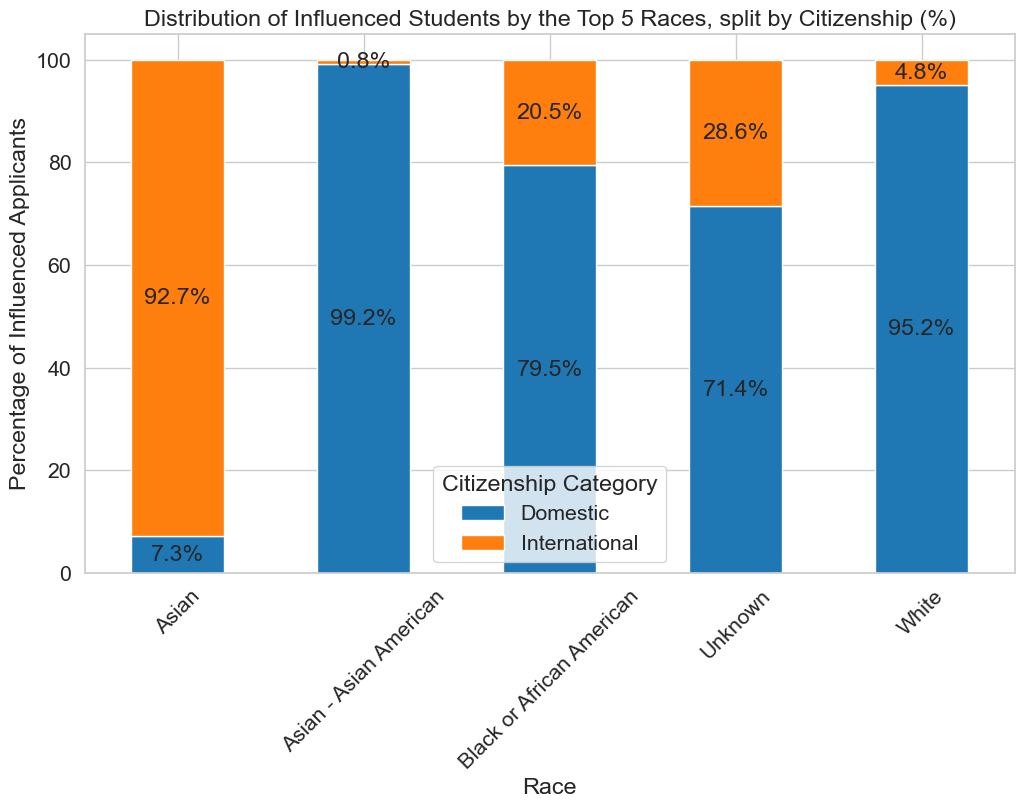

In [26]:
# Prepare data for top 5 races
race_citizenship_influenced = influenced_data[influenced_data['Person Race'].isin(top_5_races)]
race_citizenship_grouped = race_citizenship_influenced.groupby(['Person Race', 'Citizenship Category']).size().unstack().fillna(0)
race_citizenship_percentage = race_citizenship_grouped.div(race_citizenship_grouped.sum(axis=1), axis=0) * 100

# Plot the distribution of influenced students by the top 5 races, split by citizenship
plt.figure(figsize=(12, 7))
bars = race_citizenship_percentage.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
plt.title('Distribution of Influenced Students by the Top 5 Races, split by Citizenship (%)')
plt.xlabel('Race')
plt.ylabel('Percentage of Influenced Applicants')
plt.xticks(rotation=45)
plt.legend(title='Citizenship Category', labels=['Domestic', 'International'])
for bar in bars.containers:
    bars.bar_label(bar, fmt='%.1f%%', label_type='center')

plt.show()


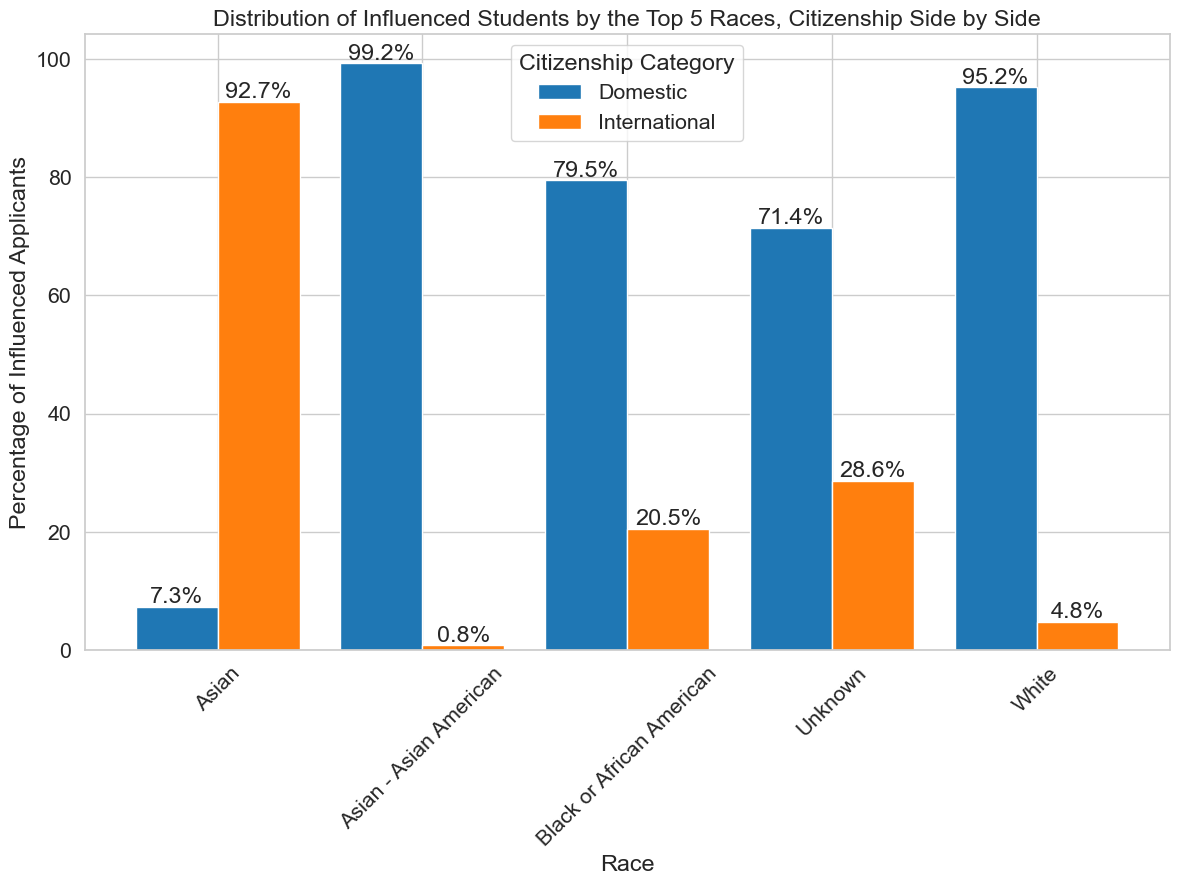

In [27]:
# Plot the distribution of influenced students by the top 5 races with side by side bars for citizenship
plt.figure(figsize=(14, 8))
bars = race_citizenship_percentage.plot(kind='bar', stacked=False, color=['#1f77b4', '#ff7f0e'], ax=plt.gca(), width=0.8)
plt.title('Distribution of Influenced Students by the Top 5 Races, Citizenship Side by Side')
plt.xlabel('Race')
plt.ylabel('Percentage of Influenced Applicants')
plt.xticks(rotation=45)
plt.legend(title='Citizenship Category', labels=['Domestic', 'International'])

# Adding percentage labels
for bar in bars.containers:
    bars.bar_label(bar, fmt='%.1f%%', label_type='edge')

plt.show()


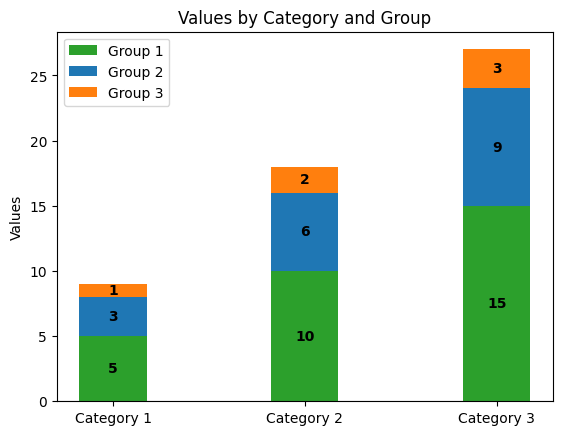

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Category 1', 'Category 2', 'Category 3']
group1 = [5, 10, 15]
group2 = [3, 6, 9]
group3 = [1, 2, 3]

ind = np.arange(len(categories))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Stacked bars
p1 = ax.bar(ind, group1, width, label='Group 1', color='#2ca02c')  # a color-blind friendly green
p2 = ax.bar(ind, group2, width, bottom=group1, label='Group 2', color='#1f77b4')  # a color-blind friendly blue
p3 = ax.bar(ind, group3, width, bottom=np.array(group1)+np.array(group2), label='Group 3', color='#ff7f0e')  # a color-blind friendly orange

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Values')
ax.set_title('Values by Category and Group')
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Text labels for better accessibility
for bars in [p1, p2, p3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + yval/2, round(yval, 1), ha='center', va='center', color='black', fontweight='bold')

plt.show()
